# strain_tools simple example

# Introduction

We will calculate strain rates across a region of the West Greenland Ice Sheet from Store Glacier to Perlefiup Sermia. These data and region of interest are the same as that of Chudley _et al._ (2021). The _vx_ and _vy_ fields provided are 2018 annual velocity fields from the _MEaSUREs Greenland Annual Ice Sheet Velocity Mosaics from SAR and Landsat_ dataset, available from the National Snow and Ice Data Centre (https://doi.org/10.5067/OBXCG75U7540; Joughin, 2010). 

> Chudley _et al._ (2021). Controls on water storage and drainage in crevasses on the Greenland Ice Sheet. _Journal of Geophysical Research: Earth Surface_, _126_, e2021JF006287. https://doi.org/10.1029/2021JF006287

> Joughin (2010). Greenland Flow Variability from Ice-Sheet-Wide Velocity Mapping. _Journal of Glaciology_. _56_. 415-430. https://doi.org/10.3189/002214310792447734


## Housekeeping

Load modules:

In [1]:
import numpy as np
import rasterio as rs
import matplotlib.pyplot as plt

import strain_tools

Sort display options:

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

## Load and clean velocity fields

In [3]:
vx_fpath = "data/vel2018_vx.tif"
vy_fpath = "data/vel2018_vy.tif"

# read array
with rs.open(vx_fpath) as src:
    vx = src.read(1)
    vx = np.where(vx == 0, np.nan, vx)

with rs.open(vy_fpath) as src:
    vy = src.read(1)
    vy = np.where(vy == 0, np.nan, vy)
    
    # get extent, for plotting
    xmin, ymin, xmax, ymax = src.bounds
    extent = (xmin, xmax, ymin, ymax)
    
    # Get meshgrid of coordinate locations, for stream and quiver plots
    height = np.arange(vy.shape[0])
    width = np.arange(vy.shape[1])
    X_pixels, Y_pixels = np.meshgrid(width, height)
    gt = src.transform  # get geotransform to transform meshgrid into geospatial coordinates
    X = gt[0] + (X_pixels + 0.5) * gt[1] + (Y_pixels + 0.5) * gt[2] 
    Y = gt[3] + (X_pixels + 0.5) * gt[4] + (Y_pixels + 0.5) * gt[5]
    # coordinates are at centre-cell, therefore the +0.5
    

/home/chudley.1/envs/geopy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


Visualise velocity...

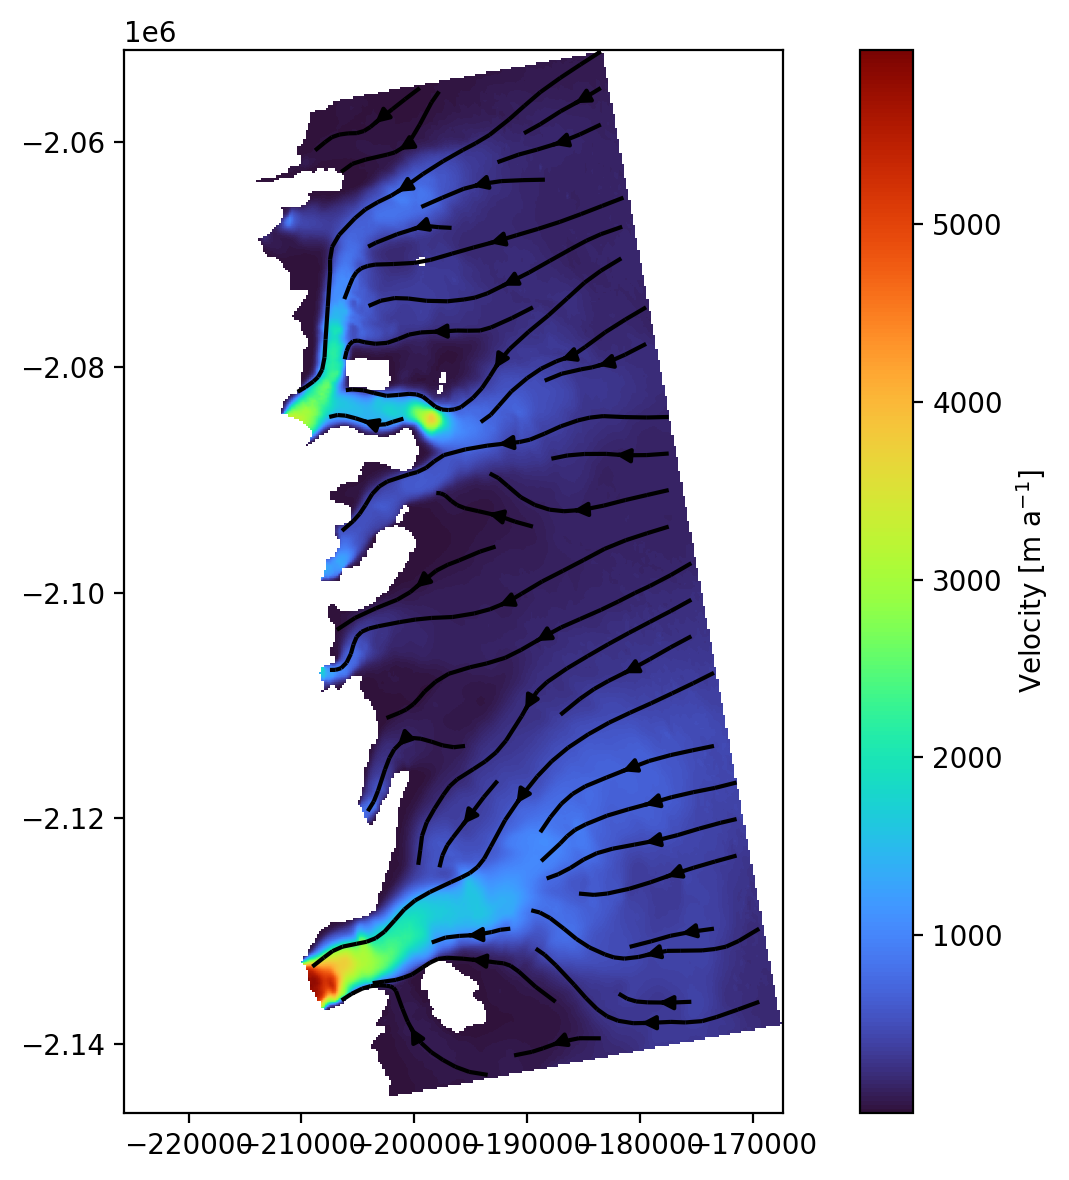

In [4]:
# get absolute velocity
vv = np.sqrt(vx**2 + vy**2)

plt.figure(figsize=(8,6))

im = plt.imshow(vv, cmap="turbo", extent=extent)
strm = plt.streamplot(X, Y, vx, vy, color="k")
cbar = plt.colorbar(im, label="Velocity [m a$^{-1}$]")

# plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

## Calculate log strains

In [5]:
resolution = 200    # metres
length_scale = 750  # metres

In [6]:
e_xx, e_yy, e_xy = strain_tools.log_strain_rate(vx, vy, resolution, length_scale)

In [7]:
e_1, e_1U, e_1V, e_2, e_2U, e_2V, e_M = strain_tools.principal_strain_rate_directions(
    e_xx, e_yy, e_xy
)

In [8]:
e_1_alt, e_2_alt, e_M_alt = strain_tools.principal_strain_rate_magnitudes(
    e_xx, e_yy, e_xy
)

In [9]:
# Difference between two methods used to calculate principal strain rates are minimal - 
# related to different numpy methods, floating points, etc.
print(np.nanmean(np.abs(e_1 - e_1_alt)))
print(np.nanmean(np.abs(e_2 - e_2_alt)))

4.579402927940203e-18
4.756247255993881e-18


In [10]:
angle = strain_tools.flow_direction(vx, vy)
e_lon, e_trn, e_shr = strain_tools.rotated_strain_rates(e_xx, e_yy, e_xy, angle)
e_E = strain_tools.effective_strain_rate(e_xx, e_yy, e_xy)

## Visualising results

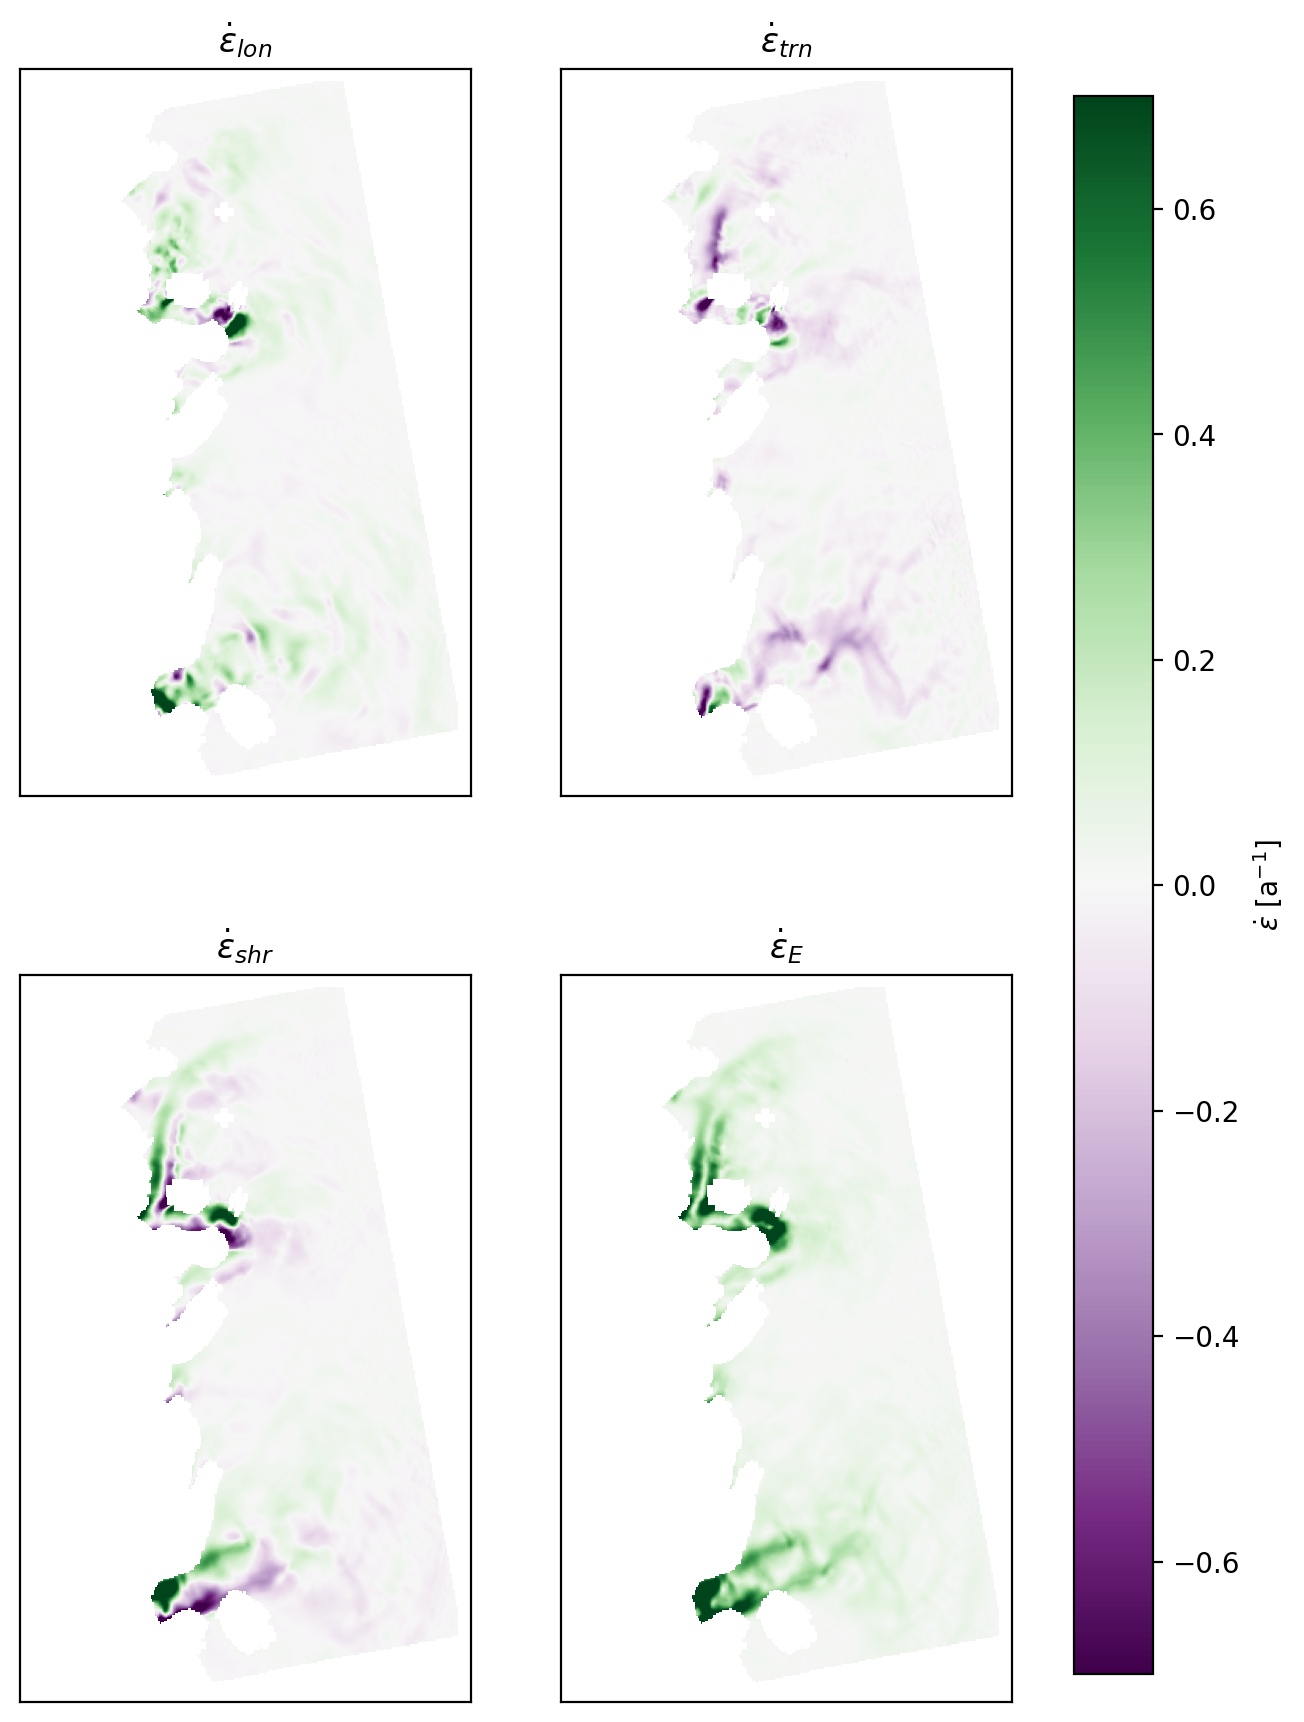

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,11), sharex=True, sharey=True)

vmax = 0.7

labels = ("$\dot{\epsilon}_{lon}$", "$\dot{\epsilon}_{trn}$", "$\dot{\epsilon}_{shr}$", "$\dot{\epsilon}_{E}$")

for ax, array, label in zip(axes.flat, (e_lon, e_trn, e_shr, e_E), labels):
    im = ax.imshow(array, extent=extent, cmap="PRGn", vmin=-vmax, vmax=vmax)
    ax.set_title(f"{label}")
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label("$\dot{\epsilon}$ [a$^{-1}$]")

plt.show()

<IPython.core.display.Javascript object>


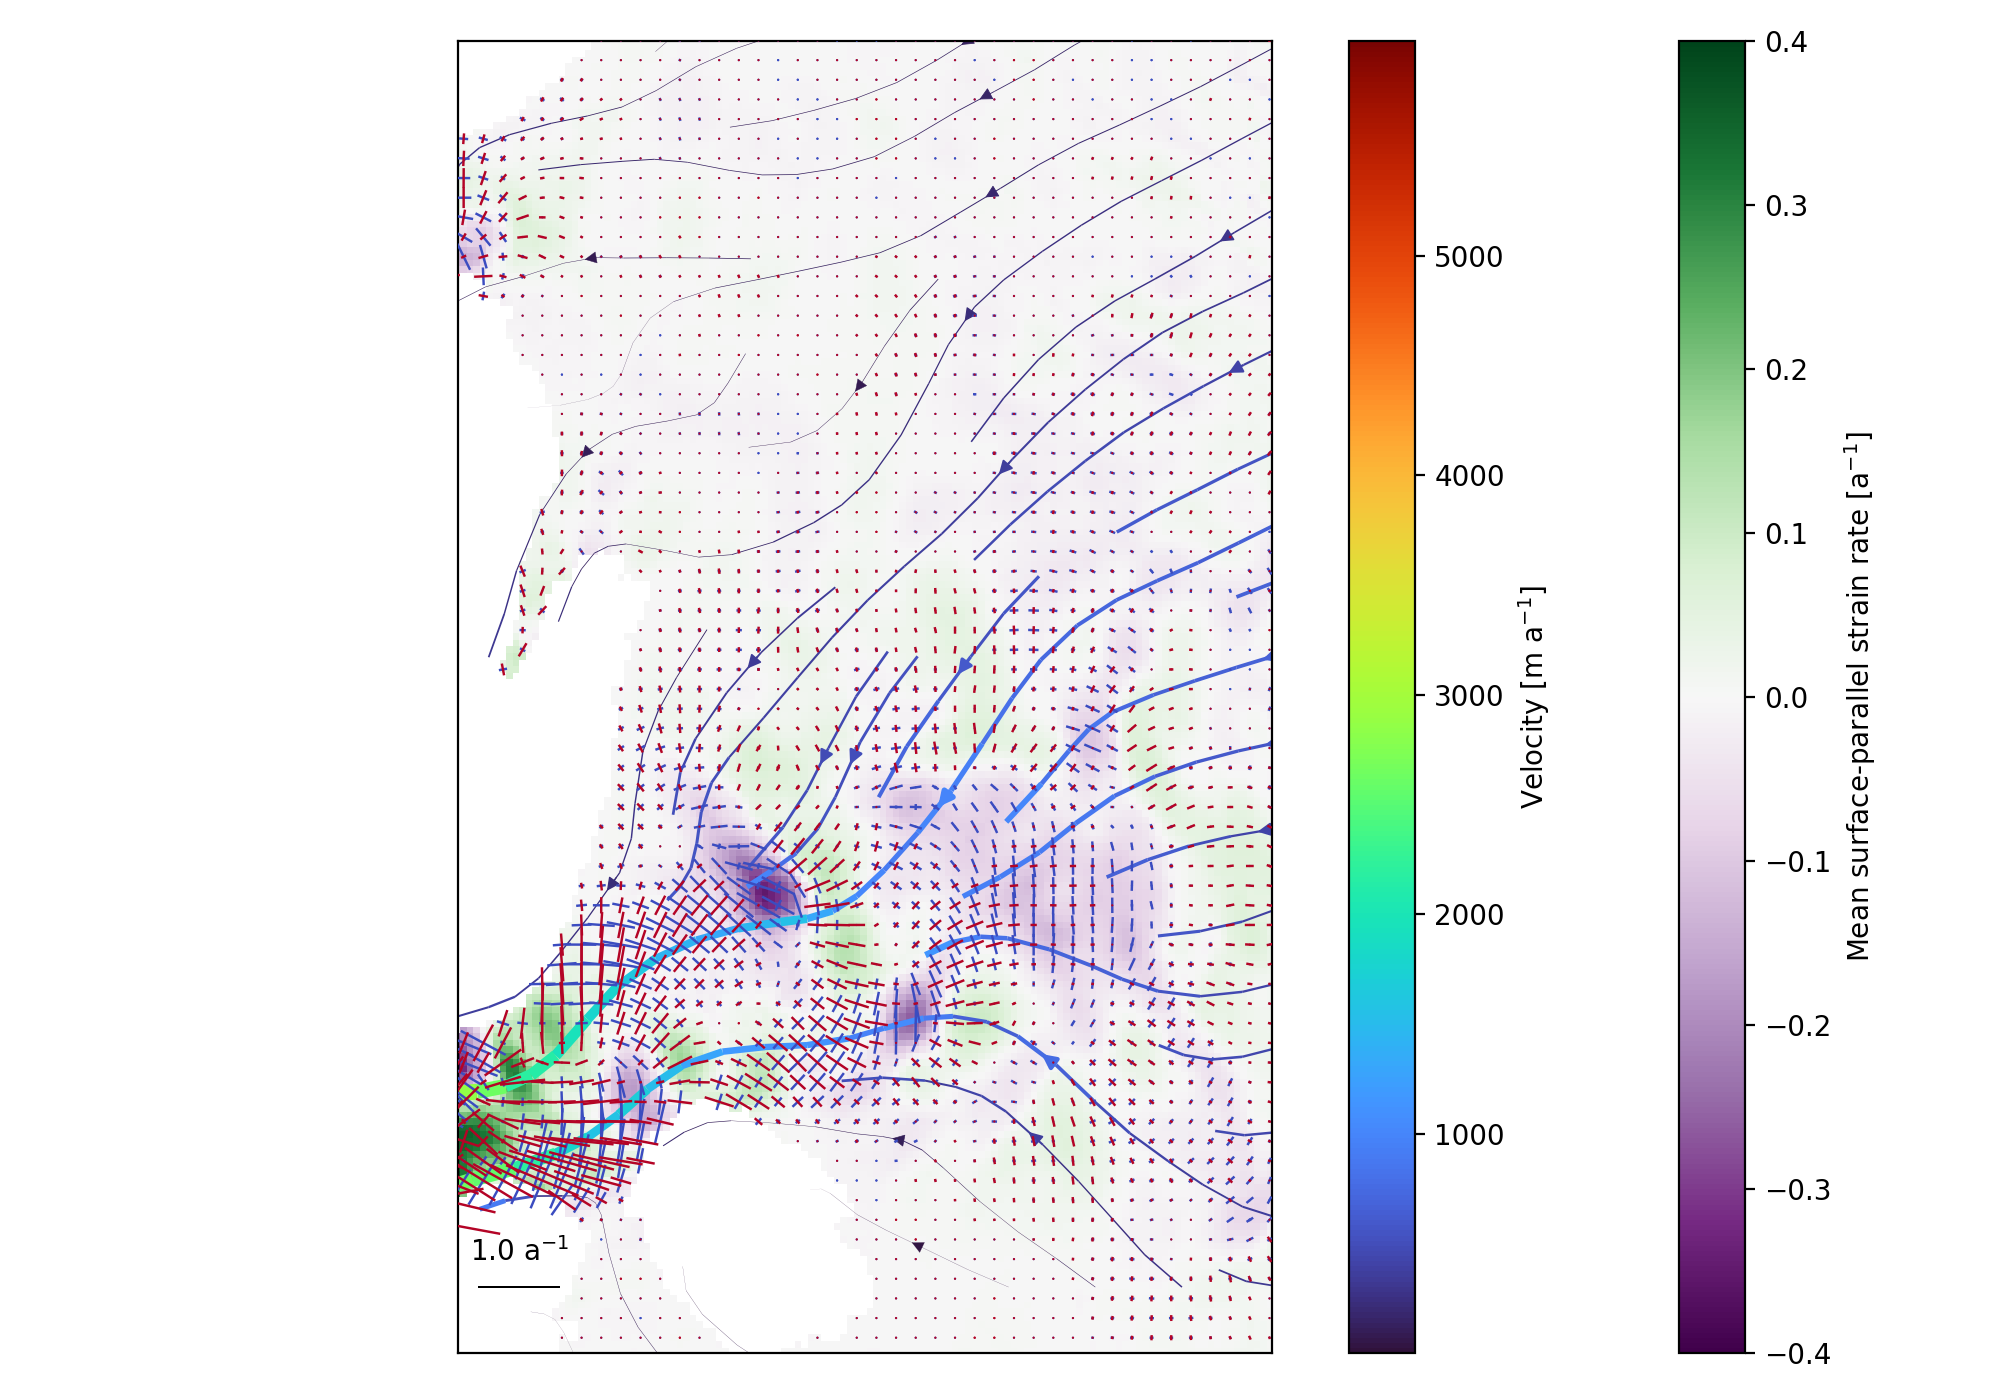

In [12]:
# set to notebook mode to allow panning for presentation purposes
%matplotlib notebook

# Settings for satellite data
vmax = 0.4        # Set colour extent for background image
arrowsize = 0     # Set arrows to zero so as not to visualise
lw = .003         # Line width
arrowscale = 10   # Scale length of arrows. General: 20-30. Inland: 3
show_every = 3    # Show principal strain cross every n grid cells

# Plot every Nth quiver as per https://stackoverflow.com/questions/33576572/python-quiver-options
skip = (slice(None, None, show_every), slice(None, None, show_every))

# Derive appropriate colours for extensional and compressional quivers
with np.errstate(invalid='ignore'):  # ignore runtime warnings in comparisons against np.nans
    e1colour = np.where(e_1 > 0, 1, -1)
    e2colour = np.where(e_2 > 0, 1, -1)
    
plt.figure(figsize=(10,7))
ax = plt.gca()

# Plot strain
im = ax.imshow(e_M, cmap="PRGn", extent=extent, vmin=-vmax, vmax=vmax)
cbar = plt.colorbar(im, label="Mean surface-parallel strain rate [$\mathregular{a^{-1}}$]")

# Plot streamplot
strm = ax.streamplot(X, Y, vx, vy, color=vv, cmap="turbo", linewidth=vv/500, density=1.5)
# strm = ax.streamplot(X, Y, vx, vy, color="k", linewidth=vv/10, density=4)
cbar = plt.colorbar(strm.lines, label="Velocity [m $\mathregular{a^{-1}}$]")

# Plot second principal strain
e2_qvr = ax.quiver( X[skip], Y[skip], e_2U[skip],  e_2V[skip], e2colour[skip], scale=arrowscale, cmap='coolwarm', clim=(-1, +1),
                 pivot='mid', headaxislength=arrowsize, headlength=arrowsize, width=lw, zorder=3)
# Plot first principal strain
e1_qvr = ax.quiver( X[skip], Y[skip], e_1U[skip],  e_1V[skip], e1colour[skip], scale=arrowscale, cmap='coolwarm', clim=(-1, +1),
                pivot='mid', headaxislength=arrowsize, headlength=arrowsize, width=lw, zorder=3)


# Plot quiver key
quivlength = arrowscale/10
unit=' $\mathregular{a^{-1}}$'
plt.quiverkey(e1_qvr, X=.075, Y=0.05, U=quivlength, labelpos='N', label=str(quivlength)+unit, color='k', labelcolor='k')

# Wrap up
ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.tight_layout()
plt.show()